# K-Means Algorithm

This notebook will present the development of the k-means algorithm done by my incredible self !

The goal here is not to use scikit-learn straight ahead, but rather to learn by myself how k-means works under the hood and what are the different mechanisms ruling it.

So Now lets go baby !

In [76]:
import numpy
from sklearn import datasets

class NaiveKMeans:
    """
    In this implementation of k-means algorithm we are going to do it the naive way, meaning with very few numpy function and optimization, the implementation mostly working in pure python.
    This is far from optimal on a practical point of view but this serves the purpose of learning how things actually work by doing them ourselves.
    """
    def __init__(self, data: numpy.ndarray):
        # Retrieve the data
        self.X = data
        # Retrieve the number of datapoints we got
        self.n_rows = self.X.shape[0]
        # Declare variables that will be set up once we call the k-means main method
        self.k = None
        self.mu = None
        self.A_shape = None
        self.A = None
        self.distances = None
        
    def setup(self, k: int):
        self.k = k
        # First initialization of mu (the matrix of centroids)
        random_indices = numpy.random.choice(self.n_rows, self.k, replace=False) # Select k random indices in order to pick k random datapoints to start with.
        self.mu = self.X[random_indices,:] # (k,4) matrix
        # Affectation matrix
        self.A_shape = (self.n_rows, self.k) 
        self.A = numpy.zeros(self.A_shape)
        # Distance matrix distances[i,j] is the distance between the datapoint i and the centroid j.
        self.distances = numpy.zeros(self.A_shape)
        
    
    def compute_affectation_matrix(self, debug: bool = False):
        # First, compute the distances of every datapoint to every centroid
        for i in range(self.n_rows):
            for j in range(self.k):
                # calculate the squared euclid distance for each sample i against the centroid j
                self.distances[i,j] = numpy.sum(numpy.square(self.X[i] - self.mu[j]))
        
        # Then, retrieve the argmin (ie. the index of the smallest element in each row)
        argmin = numpy.argmin(self.distances, axis=1)
        
        # Initialize an affectation matrix to 0 of shape (n,k)
        self.A = numpy.zeros(self.A_shape)
        for i, j in enumerate(argmin):
            # Set only the smallest element to 1
            self.A[i,j] = 1
        
    def compute_centroids_matrix(self):
        # Update every centroids j
        for j in range(self.k):
            sum_vector_cluster_j = 0
            div = 0
            for i in range(self.n_rows):
                sum_vector_cluster_j += self.A[i,j] * self.X[i]
                div += self.A[i,j]
            self.mu[j] = sum_vector_cluster_j / div
            
    def loss_function(self):
        loss = 0
        for i in range(self.n_rows):
            for j in range(self.k):
                if self.A[i,j]:
                    loss += self.distances[i,j]
        return loss
    
    def verif(self):
        """
        This function only makes sense for k = 3 as it is the actual number of clusters there are in the dataset.
        For other values of k, trying to look for a mapping of our clusters to the actual one is useless as there wouldn't be the same number of clusters.
        :return: the number of correctly clustered datapoints
        """
        # todo: improve this function to make it more versatile
        possible_mappings = [[0]*3 for _ in range(3)]
        a = numpy.argmax(self.A, axis=1)
        b = datasets.load_iris().target
        for el_a, el_b in zip(a, b):
            possible_mappings[el_a][el_b] += 1
            
        mapping = numpy.argmax(possible_mappings, axis=1)
        return sum(mapping[predicted] == b[i] for i, predicted in enumerate(a))
    
    def k_means(self, k: int) -> (float, int):
        """
        Method where we actually run the k-means algorithm by calling other method.
        The basic idea here is to compute a loss function at each turn of the loop.
        We iterate until the loss converge.
        At each iteration we update the affectation matrix, then the centroids.
        :return: 
        """
        # First set up the instance to work with k clusters
        self.setup(k)
        
        # Initialize loss variables
        previous_loss, curr_loss = -1, self.loss_function()
        
        nb_ite = 0
        
        # Iterate until we converge
        while curr_loss != previous_loss:
            nb_ite += 1
            # Update the affectation matrix
            self.compute_affectation_matrix()
            # Update the centroids
            self.compute_centroids_matrix()
            # Recompute the loss function
            previous_loss, curr_loss = curr_loss, self.loss_function()
            
        return curr_loss, nb_ite  # print(f"{self.verif()} predictions were correct out of {self.n_rows} datapoints. Hence {self.verif()/self.n_rows*100:.2f}%")
    
    def elbow_curve(self, lower: int, upper: int, save: bool = False):
        values = [self.k_means(k) for k in range(lower, upper)]
        elbow, _ = zip(*values)
        
        # Plot the elbow curve and save it to a file if the flag is enabled
        _, ax = plt.subplots()
        ax.plot(range(lower, upper), elbow)
        ax.set(xlabel="Number of clusters", ylabel="Loss", title="Elbow Curve")
        if save:
            plt.savefig("elbow_curve.png")
            
    def plot_iterations(self, lower: int, upper: int, save: bool = False):
        values = [self.k_means(k) for k in range(lower, upper)]
        _, iterations = zip(*values)
        
        # Plot the bar chart of the number of iterations for each k and save it to a file if the flag is enabled
        _, ax = plt.subplots()
        ax.bar(range(lower, upper), iterations)
        ax.set(xlabel="Number of clusters", ylabel="Number of iterations", title="Iterations")
        if save:
            plt.savefig("iterations.png")


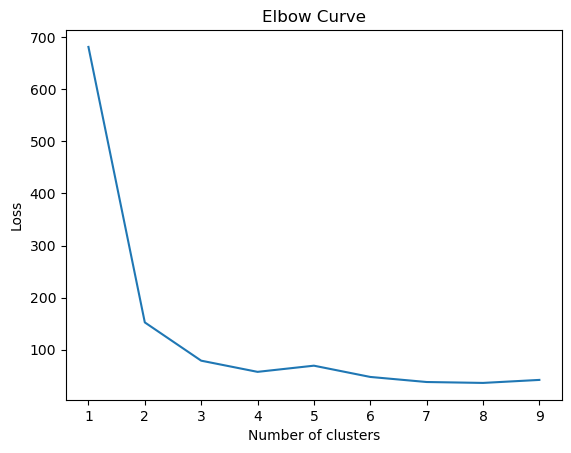

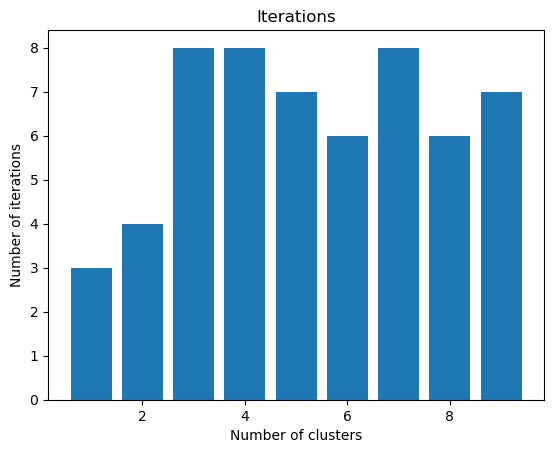

In [77]:
import matplotlib.pyplot as plt

dt = datasets.load_iris().data
algo = NaiveKMeans(dt)

algo.elbow_curve(1, 10)
algo.plot_iterations(1, 10)



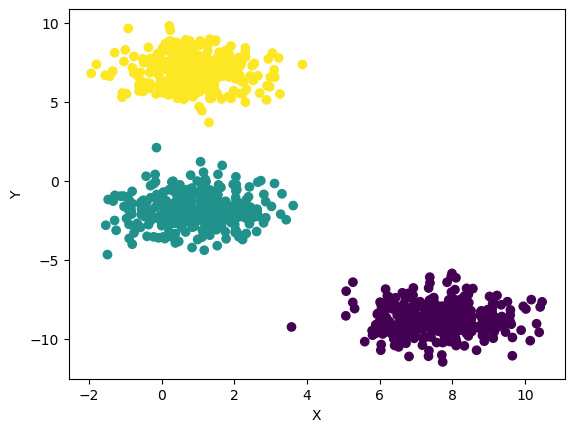

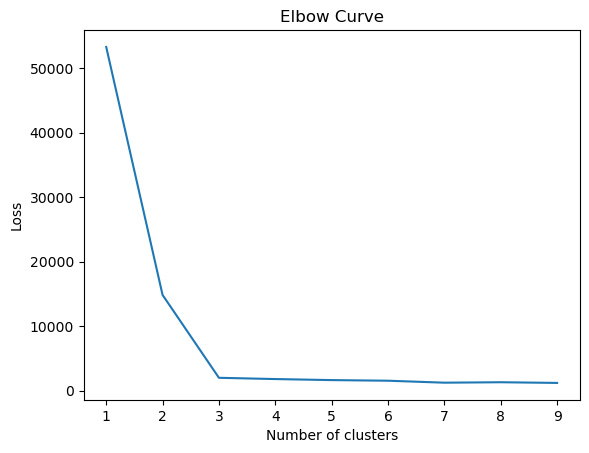

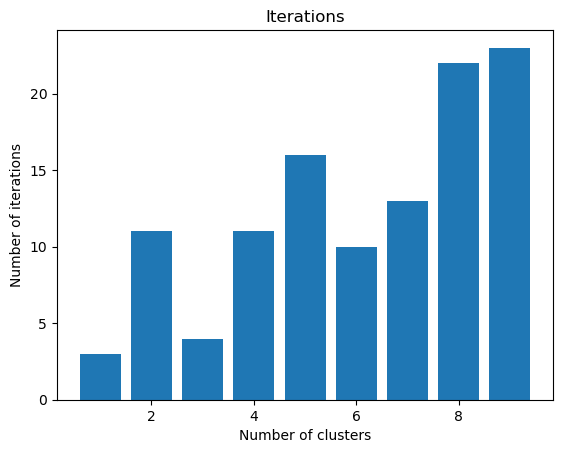

In [114]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=1)

_, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set(xlabel="X", ylabel="Y")

algo = NaiveKMeans(X)

algo.elbow_curve(1, 10)
algo.plot_iterations(1, 10)

In [ ]:
# TODO : 
#  - add a method that returns the labels (cluster assignations) for each datapoints
#  - implement an improved version of k-mean using numpy 
#  - implement k-mean with sklearn
#  - implement k-median
#  - time those implementation
